# Spam Model using Keras
## Imports

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


2022-09-25 16:43:40.699014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 16:43:41.420174: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-25 16:43:42.717884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-25 16:43:42.718077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Import dataset and normalize

In [2]:
# Read data
data = pd.read_csv('./input/MatrixData', sep='\t')


def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (
        word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)
    
# Convert label to something useful
data.dropna(inplace=True)
def change_labels(x): return 1 if x == "spam" else 0
data['label'] = data['label'].apply(change_labels)
data['message'] = data['message'].apply(
    remove_stopwords)

data = data.sample(frac=1).reset_index(drop=True)
sentences = data['message'].tolist()
labels = data['label'].tolist()

# Separate out the sentences and labels into training and test sets
#training_size = int(len(sentences) * 0.8)
training_size = int(len(sentences) * 0.7)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenize

In [3]:
vocab_size = 1000
embedding_dim = 16
#max_length = 120
max_length = None
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [4]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type,
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

## Model

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(.5,),
    tf.keras.layers.Dense(6, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(.5,),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam', metrics=['accuracy'])
model.summary()


2022-09-25 16:43:45.621721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-25 16:43:45.777165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-25 16:43:45.777250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-25 16:43:45.779091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                        

] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2022-09-25 16:43:47.268086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-25 16:43:47.268497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5904 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


### Train

In [6]:
from datetime import datetime
from tensorflow import keras
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
# Define the checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
# Define the name of the checkpoint files.
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

#es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [7]:
num_epochs = 200
history = model.fit(padded, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    verbose=0, 
                    callbacks=[tensorboard_callback, 
                                tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                                   save_weights_only=True),
                               #es_callback
                    ],
                    validation_data=(testing_padded, testing_labels_final))

print("Average train loss: ", np.average(history.history['loss']))
print("Average test loss: ", np.average(history.history['val_loss']))


Average train loss:  0.09642073692753911
Average test loss:  0.10952864557504655


INFO:tensorflow:Assets written to: ./models/spam_keras_1664117260.1010098/assets


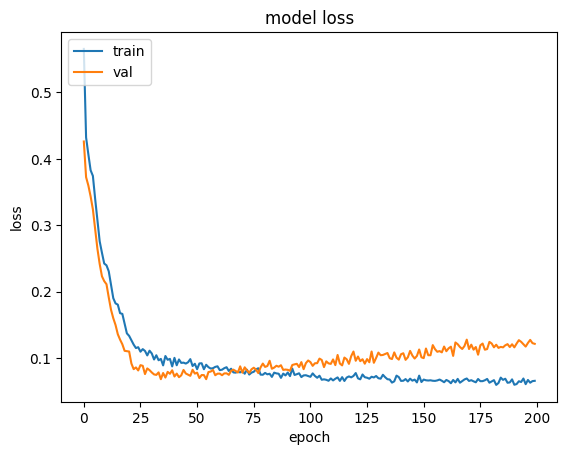

In [8]:
# Save model
import time
model.save(f"./models/spam_keras_{time.time()}")

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Use the model to predict whether a message is spam
text_messages = ['Greg, can you call me back once you get this?',
                 'Congrats on your new iPhone! Click here to claim your prize...',
                 'Really like that new photo of you',
                 'Did you hear the news today? Terrible what has happened...',
                 'Attend this free COVID webinar today: Book your session now...',
                 'Are you coming to the party tonight?',
                 'Your parcel has gone missing',
                 'Do not forget to bring friends!',
                 'You have won a million dollars! Fill out your bank details here...',
                 'Looking forward to seeing you again',
                 'oh wow https://github.com/MGCodesandStats/tensorflow-nlp/blob/master/spam%20detection%20tensorflow%20v2.ipynb works really good on spam detection. Guess I go with that as the base model then lol :D',
                 'ayo',
                 'Almost all my spam is coming to my non-gmail address actually',
                 'Oh neat I think I found the sizing sweetspot for my data :D',
                 'would never click on buttons in gmail :D always expecting there to be a bug in gmail that allows js to grab your google credentials :D XSS via email lol. I am too scared for touching spam in gmail',
                 'back to cacophony ',
                 'Room version 11 when',
                 'skip 11 and go straight to 12',
                 '100 events should clear out any events that might be causing a request to fail lol']

print(text_messages)

# Create the sequences
padding_type = 'post'
sample_sequences = tokenizer.texts_to_sequences(text_messages)
fakes_padded = pad_sequences(
    sample_sequences, padding=padding_type, maxlen=max_length)

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(text_messages)):
  print(f"Message: \"{text_messages[x]}\"")
  print(f"Likeliness of spam in percentage: {classes[x][0]}")
  print('\n')


['Greg, can you call me back once you get this?', 'Congrats on your new iPhone! Click here to claim your prize...', 'Really like that new photo of you', 'Did you hear the news today? Terrible what has happened...', 'Attend this free COVID webinar today: Book your session now...', 'Are you coming to the party tonight?', 'Your parcel has gone missing', 'Do not forget to bring friends!', 'You have won a million dollars! Fill out your bank details here...', 'Looking forward to seeing you again', 'oh wow https://github.com/MGCodesandStats/tensorflow-nlp/blob/master/spam%20detection%20tensorflow%20v2.ipynb works really good on spam detection. Guess I go with that as the base model then lol :D', 'ayo', 'Almost all my spam is coming to my non-gmail address actually', 'Oh neat I think I found the sizing sweetspot for my data :D', 'would never click on buttons in gmail :D always expecting there to be a bug in gmail that allows js to grab your google credentials :D XSS via email lol. I am too sca

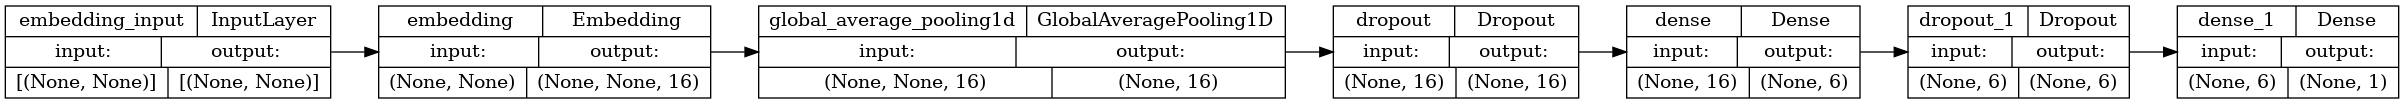

In [10]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)
